In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import colorsys
from PIL import ImageColor 

import pathlib
from tifffile import imread

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from textwrap import wrap
from matplotlib.patches import Patch
#mycol = ["red", "darkorange", "yellow", "limegreen", "dodgerblue", "darkviolet", "deeppink" ]
mycol = ["red", "green", "blue"]
import warnings
warnings.filterwarnings("ignore")

# Functions for Plotting

In [3]:
# Create dummy scatter plots using various marker types
# The multiple overlaid datasets are distringuished not only by colour but also by shape
# We prepare custom marker shapes (e.g. circles, triangles, +) from scatter plot artists in matplotlib, then apply those markers to a new plot

fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='o')
b = ax.scatter([1,2],[2,4], marker='X')
c = ax.scatter([1,5],[3,4], marker='+')
d = ax.scatter([2,2],[3,4], marker='v')
e = ax.scatter([3,2],[3,4], marker='^')
f = ax.scatter([3,2],[4,4], marker='<')
g = ax.scatter([1,2],[1,4], marker='>')
h = ax.scatter([1,2],[2,4], marker='.')
i = ax.scatter([1,2],[3,4], marker=',')
j = ax.scatter([0,0],[5,4], marker='1')
k = ax.scatter([0,1],[0,3], marker='2')
l = ax.scatter([0,2],[1,4], marker='8')
# ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X',

square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
plus_mk, = c.get_paths()
v_mk, = d.get_paths()
up_mk, = e.get_paths()
left_mk, = f.get_paths()
right_mk, = g.get_paths()
dot_mk, = h.get_paths()
comma_mk, = i.get_paths()
one_mk, = j.get_paths()
two_mk, = k.get_paths()
three_mk, = l.get_paths()
plt.close()

def apply_markers(ax):
    """
    Assign custom marker shapes to each colour group in a matplotlib Axes object.

    Parameters:
    ----------
    ax : matplotlib.axes.Axes
        The Axes object containing scatter plot collections where each colour group
        will be assigned a unique marker path.

    Notes:
    -----
    - The marker shapes used are predefined and mapped to colours based on order.
    - This function assumes that the number of unique colours does not exceed
      the number of predefined markers.
    - Useful for making scatter plots more accessible or visually distinct beyond colour.
    """
    collections = ax.collections
    unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
    markers = [triangle_up_mk, square_mk, plus_mk, v_mk, up_mk, left_mk, right_mk, dot_mk, comma_mk, one_mk, two_mk, three_mk]  # this array must be at least as large as the number of unique colors
    for collection in collections:
        paths = []
        for current_color in collection.get_facecolors():
            for possible_marker,possible_color in zip(markers, unique_colors):
                if np.array_equal(current_color,possible_color):
                    paths.append(possible_marker)
                    break
        collection.set_paths(paths)

In [4]:
def create_n_valued_palette(base_color_hex, n=14):
    """
    Generate a palette of `n` RGB colours by varying the lightness of a base colour.

    Parameters:
    ----------
    base_colour_hex : str
        Base colour in hexadecimal format (e.g., "#1E90FF") to derive the palette from.
    n : int, default=14
        Number of distinct colours to generate.

    Returns:
    -------
    palette : list of tuples
        A list of `n` RGB colour tuples (with values between 0 and 1).
        The colours vary in lightness while maintaining the base hue and saturation.

    Notes:
    -----
    - Lightness is scaled between 60% and 140% of the original value, clipped to [0, 1]. Can increase the range for greater contrast
    - Useful for generating visually related colours with consistent tone and hue.
    """
    r,g,b = ImageColor.getcolor(base_color_hex, "RGB")[0], ImageColor.getcolor(base_color_hex, "RGB")[1], ImageColor.getcolor(base_color_hex, "RGB")[2]
    r=r/255
    g=g/255
    b=b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    lightness_adjustments = np.linspace(0.6, 1.4, n)  # Creating a range of values
    # Create the palette with adjusted lightness while keeping hue and saturation constant
    palette = [colorsys.hls_to_rgb(h, min(max(l * adj, 0), 1), s) for adj in lightness_adjustments]

    return palette

palette_14_limegreen = create_n_valued_palette("#32CD32")
palette_14_dodgerblue = create_n_valued_palette("#1E90FF")
palette_14_red = create_n_valued_palette("#FF0000")    

In [ ]:
def plot_acinar_differences(data, parameter,color="k", spacing = 0.2, figsize=(5,6)):
    """
    Plot per-acinus values across experimental conditions and timepoints using split-panel swarm and box plots.
    Because the conditions are different on different days (blank only d0, soft + stiff for subsequent days) we use overlaid plots

    Parameters:
    ----------
    data : pd.DataFrame
        A DataFrame containing at least the following columns:
        - 'day' (int): timepoint (e.g., 0, 1, 3, 7)
        - 'condition' (str): treatment condition ('soft', 'stiff', etc.)
        - 'Key_index' (str or int): identifier for each acinus or replicate
        - [parameter] (float): the measurement to be visualized on the y-axis.
    parameter : str
        The name of the parameter column in `data` to plot on the y-axis.
    color : str, default='k'
        Colour for the median, whisker, and cap lines of the boxplots.
    spacing : float, default=0.2
        Horizontal space between paired condition plots.
    figsize : tuple, default=(5, 6)
        Size of the overall matplotlib figure.

    Returns:
    -------
    None
        The function displays a multi-panel figure showing per-acinus distributions
        (via swarm plots) and medians/IQRs (via boxplots) for:
        - Day 0 (blank)
        - Day 1, 3, and 7 under both 'soft' and 'stiff' conditions

    Notes:
    -----
    - Each paired timepoint is shown side-by-side ('soft' on the left, 'stiff' on the right).
    - Colour-coded by condition: red (blank), limegreen (soft), dodgerblue (stiff).
    - Custom markers are applied using `apply_markers()` for consistent group distinction.
    - Axis cleanup and xtick labels improve layout clarity.
    - The x-axis represents time (days), and the y-axis shows the value of the selected parameter.
    """
    day_axis_dict ={0:0, 1:2, 3:5, 7:8}
    properties = dict(color=color)
    width_ratios=[1,spacing,1.5,1.3,spacing,1.5,1,spacing,1.5,1]
    gridspec = dict(hspace=0.0, wspace=0.01, width_ratios=width_ratios)
    fig, ax = plt.subplots(nrows = 1, ncols = len(width_ratios), figsize=figsize, gridspec_kw = gridspec)
    days = data["day"].unique()
    days.sort()

    for i, day in enumerate(data["day"].unique()):
        if day == 0:
            sns.swarmplot(data = data[data["day"]==day],  y=parameter, hue="Key_index", palette =palette_14_red, x="day",legend=None, ax = ax[0], size=5, alpha=1)
            sns.boxplot(data = data[data["day"]==day],  y=parameter, palette = "hsv", x="day", boxprops={'facecolor':'None', "edgecolor":"None"}, whiskerprops = properties, capprops = properties, medianprops = properties, ax = ax[0], whis=0, fliersize=0, zorder=100)

        if day != 0:
            sns.swarmplot(data = data[(data["condition"]=="soft") & (data["day"]==day)],  y=parameter, x="day", hue="Key_index", legend=None,  palette = palette_14_limegreen,  ax = ax[day_axis_dict[day]], size=5, alpha=1)
            sns.boxplot(data = data[(data["condition"]=="soft") & (data["day"]==day)],  y=parameter, x="day", palette = "hsv", boxprops={'facecolor':'None', "edgecolor":"None"}, whiskerprops = properties, capprops = properties, medianprops = properties, ax = ax[day_axis_dict[day]], whis=0, fliersize=0,zorder=100)
            
            sns.swarmplot(data = data[(data["condition"]=="stiff") & (data["day"]==day)],  y=parameter, x="day",hue="Key_index",  legend = None, palette = palette_14_dodgerblue, ax = ax[day_axis_dict[day]+1], size=5, alpha=1)
            sns.boxplot(data = data[(data["condition"]=="stiff") & (data["day"]==day)],  y=parameter, x="day",palette = "hsv", boxprops={'facecolor':'None', "edgecolor":"None"}, whiskerprops = properties, capprops = properties, medianprops = properties, ax = ax[day_axis_dict[day]+1], whis=0, fliersize=0,zorder=100)
    ax[0].set_ylabel (ax[0].yaxis.get_label().get_text().replace("_", " "), fontsize=14)

    for i, a in enumerate(ax):
        a.set_xlabel("")
        a.set_ylim(0.95*data[parameter].min(), 1.05*data[parameter].max())
        if i != 0 and i != len(ax)-1:
            a.spines["left"].set_visible(False)
            a.spines["right"].set_visible(False)
            a.yaxis.set_visible(False)
        if i == 0:
            a.spines["right"].set_visible(False)
        if i == len(ax)-1:
            a.spines["left"].set_visible(False)
            a.yaxis.set_visible(False)
        
    fig.text(0.5, 0.04, 'Day', va='center', ha='center', fontsize=14)

    legend_elements = [Patch(facecolor="red", edgecolor=color,  label='Blank'),
                        Patch(facecolor="limegreen", edgecolor=color,  label='Soft'),
                        Patch(facecolor="dodgerblue", edgecolor=color,  label='Stiff')]
                    
    lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', handles=legend_elements, framealpha=0)
    for i in ([0,2,3,5,6, 8, 9]):
        if i <= 3*len(days)-3:
            apply_markers(ax[i])
    for i in [1,3,4,6,7,9]:
        if i <= 3*len(days)-3:
            ax[i].set_xticks([])
    for i,j in enumerate([2,5,8]):
        if j < len(width_ratios)-1:
            ax[j].set_xticks([1], labels = days[i+1].astype(str))
    #plt.savefig("Acinar_cell_number.pdf", transparent = True, bbox_inches = "tight")

In [22]:
def plot_cell_differences(data, parameter, color="k",  figsize=(3,4), savetype="pdf"):
    """
    Create and save a violin plot comparing cell-level measurements across conditions and timepoints.

    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame with the following expected columns:
        - 'day' (int): indicating timepoints (e.g., 0, 1)
        - 'condition' (str): e.g., 'soft' or 'stiff' for day 1 entries
        - [parameter] (float): measurement to be plotted on the y-axis
    parameter : str
        The column name of the parameter to plot.
    color : str, default='k'
        Colour to use for quartile bars, whiskers, and legend edge outlines.
    figsize : tuple, default=(3, 4)
        Size of the generated matplotlib figure.
    savetype : str, default='pdf'
        File format for saving the figure (e.g., 'pdf', 'png').

    Returns:
    -------
    None
        The function generates and saves a side-by-side violin plot figure as:
        'cell_differences_<parameter>.<savetype>'

    Notes:
    -----
    - Day 0 ("Blank") is plotted separately on the left with a red violin.
    - Day 1 values are split into 'soft' and 'stiff' conditions and shown side-by-side on the right.
    - Violin plots display distribution and quartiles without outlier dots.
    - Colour-coded by condition: red (Blank), limegreen (Soft), dodgerblue (Stiff).
    - Shared y-axis, but y-axis ticks/labels are shown only on the left panel.
    - The output filename replaces slashes in the parameter name to ensure compatibility.
    """
    properties = dict(color=color)
    width_ratios=[1,3]
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=width_ratios)
    fig, ax = plt.subplots(nrows = 1, ncols = len(width_ratios), figsize=figsize, gridspec_kw = gridspec, sharey=True)
    days = data["day"].unique()
    days.sort()

    for i, day in enumerate([0,1]):
        if day == 0:
            sns.violinplot(data = data[data["day"]==day],  y=parameter, palette = ["red"], ax = ax[0], width=0.3, cut=0,  inner="quartile", legend=False)

        if day != 0:
            sns.violinplot(data = data[(data["day"]!=0)],  y=parameter, x="day",hue="condition", split=True, palette=["limegreen", "dodgerblue"], ax = ax[1],  width=0.4, native_scale=False, cut=0, inner="quartile", legend=False)

    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    ax[1].spines["left"].set_visible(False)
    ax[0].spines["right"].set_visible(False)
    ax[1].yaxis.set_visible(False)

    legend_elements = [Patch(facecolor="red", edgecolor=color,  label='Blank'),
                        Patch(facecolor="limegreen", edgecolor=color,  label='Soft'),
                        Patch(facecolor="dodgerblue", edgecolor=color,  label='Stiff')]
                    
    lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', handles=legend_elements, framealpha=0)
    plt.savefig("cell_differences_{}.{}".format(parameter, savetype).replace("/", "_"), bbox_inches="tight", transparent=True)

In [7]:
def protein_set(row):
    """
    Determine the protein set imaged in a microscopy file based on keywords in the filename.

    Parameters:
    ----------
    row : pd.Series
        A row from a DataFrame, expected to contain a 'filename' field (string) with relevant protein markers.

    Returns:
    -------
    str
        A string representing the protein set identified from the filename. One of:
        - 'ECad_C3'
        - 'Yap_Vinc'
        - 'Ilk'
        - 'Lam_Pax'
        - 'Talin_pFak'
        - 'Col_Beta_Cat'
        - 'Misp_Alpha_Cat'
        - 'other' (if none of the above patterns match)

    Notes:
    -----
    - Matching is case-insensitive.
    - Each condition checks for co-occurrence of specific protein name fragments in the filename.
    - Used to categorize images for grouped analysis or filtering.
    """
    if "ecad" in row['filename'].lower() and  "c3" in row['filename'].lower():
        return 'ECad_C3'
    elif "yap" in row['filename'].lower() and  "vinc" in row['filename'].lower():
        return 'Yap_Vinc'
    elif "ilk" in row['filename'].lower() :
      return 'Ilk'
    elif "lam" in row['filename'].lower() and  "pax" in row['filename'].lower():
      return 'Lam_Pax'
    elif "fak" in row['filename'].lower() and  "talin" in row['filename'].lower():
      return 'Talin_pFak'
    elif "col" in row['filename'].lower() and  "beta" in row['filename'].lower():
      return"Col_Beta_Cat"
    elif "misp" in row['filename'].lower():
       return "Misp_Alpha_Cat"
    else:
      return "other"

In [8]:
def treatment(row):
   """
    Determine treatment category based on keywords in the image filename.

    Parameters:
    ----------
    row : pd.Series
        A row from a DataFrame containing an 'image' field (string).

    Returns:
    -------
    str
        One of the following treatment labels:
        - '-4OHT' : if the image is related to BadER and represents baseline or explicitly mentions '-4oht'
        - '+4OHT' : if the image is related to BadER but doesn't match the above
        - 'ABT737' : if the image name includes '737'
        - 'None' : if no treatment keywords are matched

    Notes:
    -----
    - Matching is case-insensitive.
    - Assumes filenames contain embedded metadata keywords like 'bader', '737', 'd0', '-4oht'.
    """
   if "bader" in row['image'].lower():
      if "d0" in row["image"].lower():
         return "-4OHT"
      if "-4oht" in row['image'].lower():
         return "-4OHT"
      else:
         return "+4OHT"
   if "737" in row['image'].lower():
      return "ABT737"
   else:
      return "None"

In [9]:
def cell_line(row):
   """
    Identify the cell line used in an experiment based on the image filename.

    Parameters:
    ----------
    row : pd.Series
        A row from a DataFrame containing an 'image' field (string).

    Returns:
    -------
    str
        The cell line label:
        - 'BadER' : if the filename contains 'bader' (case-insensitive)
        - 'WT' : otherwise (wild-type by default)

    Notes:
    -----
    - This function assumes that image filenames encode experimental metadata.
    - Useful for stratifying analysis by cell line identity.
    """
   if "bader" in row['image'].lower():
      return "BadER"
   else:
      return "WT"

# Read in Data

In [16]:
root= "C:\\Users\\itayl\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Python\\Soft_Stiff_Experiment\\Shape_Size_Cells_Acini\\ShapeAndSizeOfNuclei\\Individual_Protein_Outputs"
csv_paths = list(pathlib.Path(root).glob("**/*.csv"))
data = []
for i in range(len(csv_paths)):
    data.append(pd.read_csv(csv_paths[i]))
all_data = pd.concat(data)
all_data = all_data.rename(columns={"image": "filename"})


In [17]:
# all_data.to_csv("All_cell_nuclear_vols.csv")
# all_data = pd.read_csv("All_cell_nuclear_vols.csv")

all_data["protein_set"]=all_data.apply(protein_set, axis=1)
all_data = all_data[all_data["protein_set"]!= "Ilk"]
all_data["key"] = all_data["protein_set"].astype(str) + ", well" + all_data["well"].astype(str) #the key is the same for technical replicates
all_data["key_index"] = all_data.key.map(dict(zip(all_data.key.unique(), range(all_data.key.nunique()))))

# Individual Morphological Values
- Plotting values per cell, without grouping within the acinus

In [ ]:
nuclei_data_to_plot = all_data
# When plotting anything including cells we also filter based on nucleus/cell vol and cells with 1 nucleus
cell_data_to_plot = nuclei_data_to_plot[(nuclei_data_to_plot["nucleus/cell_volume"] < 0.95) & (nuclei_data_to_plot["cell_volume_um"] < (4/3)*np.pi*(13**3))]
cell_data_to_plot["number_of_nuclei_per_cell"] = cell_data_to_plot.groupby(["filename", "cell_label"]).transform('size') #sometimes there are 2 nuclei per cell -> filter out these ones (doesn't seem to affect results at all!)
cell_data_to_plot = cell_data_to_plot[cell_data_to_plot["number_of_nuclei_per_cell"] == 1]
nuclei_data_to_plot.shape, cell_data_to_plot.shape
# cell_data_to_plot.to_csv("cell_data_to_plot.csv")
# nuclei_data_to_plot.to_csv("nuclei_data_to_plot.csv")

((72509, 20), (62099, 21))

In [61]:
# big_nuclei = all_data[(all_data["nucleus_volume_um"] > (4/3)*np.pi*(9**3))]
# big_nuclei.groupby(["condition", "day"]).size()
# plot_cell_differences(big_nuclei, "nucleus_volume_um", spacing=0.2)

In [ ]:
df_to_use = [cell_data_to_plot, cell_data_to_plot, cell_data_to_plot, cell_data_to_plot, cell_data_to_plot]
for i, param in enumerate(["nucleus_volume_um", "cell_volume_um", "nucleus/cell_volume", "cell_roundness", "nucleus_roundness"]):
    plot_cell_differences(df_to_use[i], param)

# Acinar Values
- Look at mean values per acinus

In [53]:
average_nuclear_morphology_measurements = nuclei_data_to_plot.groupby("image").mean(numeric_only=True)[["nucleus_volume_um", "nucleus_roundness"]] #mean values per acinus
average_cell_morphology_measurements = cell_data_to_plot.groupby("image").mean(numeric_only=True)[["nucleus/cell_volume", "cell_volume_um", "cell_roundness"]] #mean values per acinus
cell_numbers = nuclei_data_to_plot.groupby("image").size().to_frame('n_cells').reset_index()

In [64]:
experimental_params = cell_data_to_plot[["condition", "day", "well", "image", "internal", "external", "key_index", "key"]].drop_duplicates() # experimental info from each acinus + totals for internal/external
experimental_params= experimental_params.merge(cell_numbers)


In [65]:
average_morphology_measurements = pd.merge(experimental_params, average_nuclear_morphology_measurements, on='image')
average_morphology_measurements = pd.merge(average_morphology_measurements, average_cell_morphology_measurements, on='image')

In [66]:
average_morphology_measurements["internal/total"] = average_morphology_measurements["internal"]/average_morphology_measurements["n_cells"]
average_morphology_measurements["external/total"] = average_morphology_measurements["external"]/average_morphology_measurements["n_cells"]

In [67]:
average_morphology_measurements["Protein_Set"]=average_morphology_measurements.apply(protein_set, axis=1)
average_morphology_measurements["cell_line"]=average_morphology_measurements.apply(cell_line, axis=1)
average_morphology_measurements["treatment"]=average_morphology_measurements.apply(treatment, axis=1)
average_morphology_measurements["key"] = average_morphology_measurements["cell_line"].astype(str) + ", " + all_data["protein_set"].astype(str)  + ", well" + all_data["well"].astype(str)
average_morphology_measurements["key_index"] = average_morphology_measurements.key.map(dict(zip(all_data.key.unique(), range(all_data.key.nunique()))))
print(len(all_data["key"].unique()))
average_morphology_measurements["Key"] = average_morphology_measurements["Protein_Set"].astype(str) + ", well" + average_morphology_measurements["well"].astype(str)
average_morphology_measurements["Key_index"] = average_morphology_measurements.Key.map(dict(zip(average_morphology_measurements.Key.unique(), range(average_morphology_measurements.Key.nunique()))))
len(average_morphology_measurements["Key"].unique())
average_morphology_measurements.to_csv("average_morphology_measurements.csv")

14


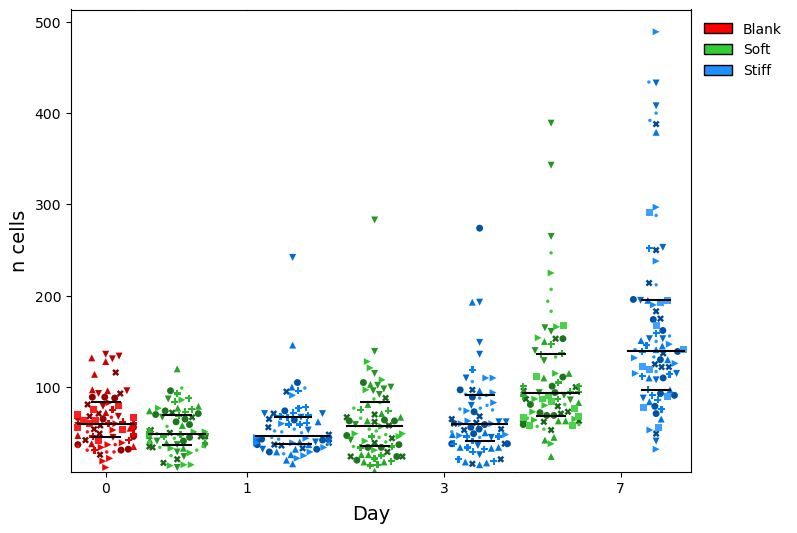

In [26]:
plot_acinar_differences(average_morphology_measurements, "n_cells", figsize=(8,6), spacing=0.01)

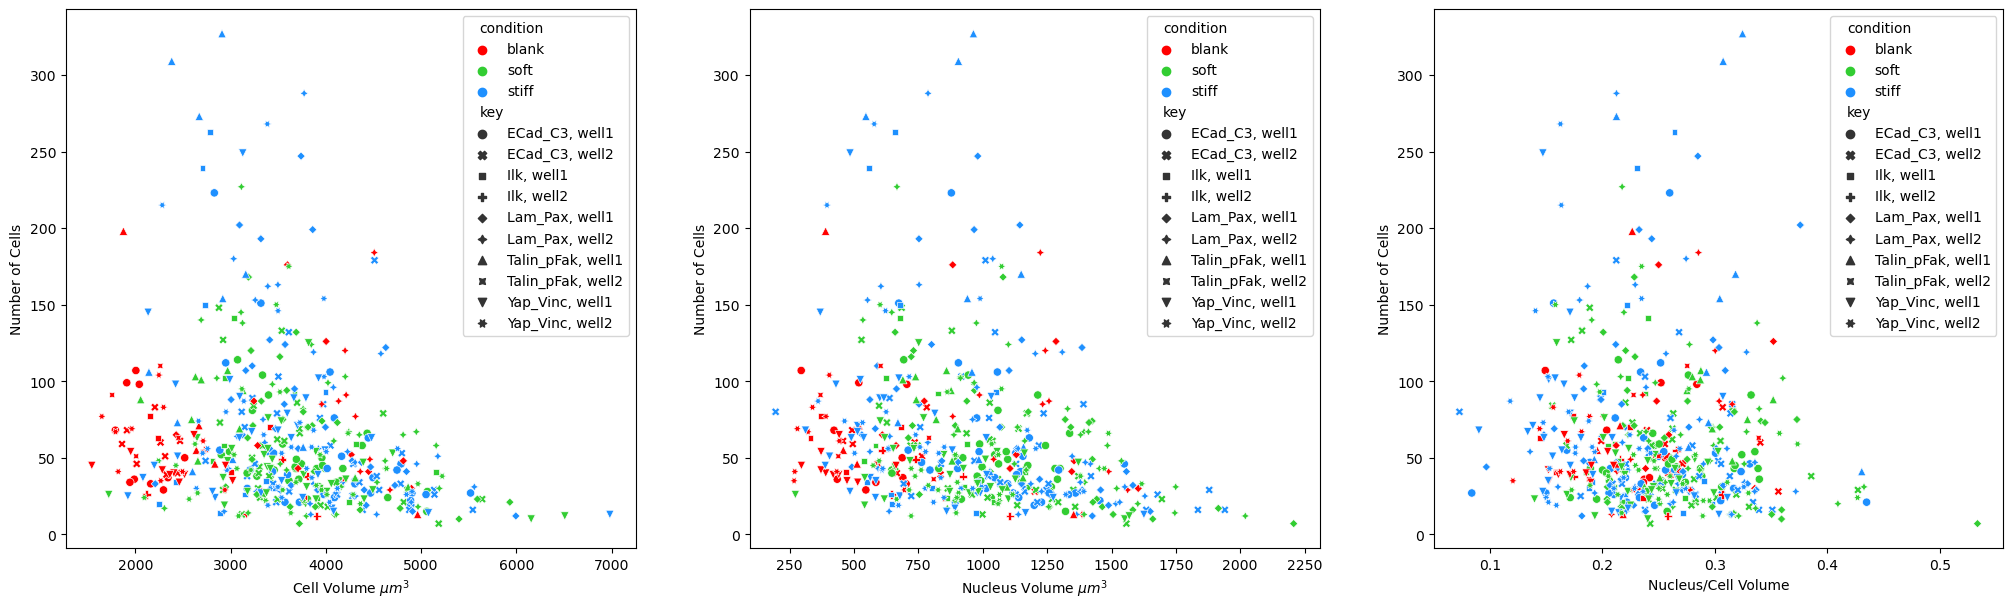

In [79]:
fig, ax = plt.subplots(ncols = 3, figsize=(25,7))
for i, param in enumerate(["cell_volume_um", "nucleus_volume_um", "nucleus/cell_volume"]):
    sns.scatterplot(data = average_morphology_measurements, x=param, y="n_cells", style="key", hue="condition", ax=ax[i], palette=["red", "limegreen", "dodgerblue"])
    ax[i].set_ylabel("Number of Cells")
    ax[i].set_xlabel(param.replace("_", " ").title().replace("Um", r"$\mu m^3$"))

In [46]:
## just plot either soft, stiff or blank, look for trends and correlation

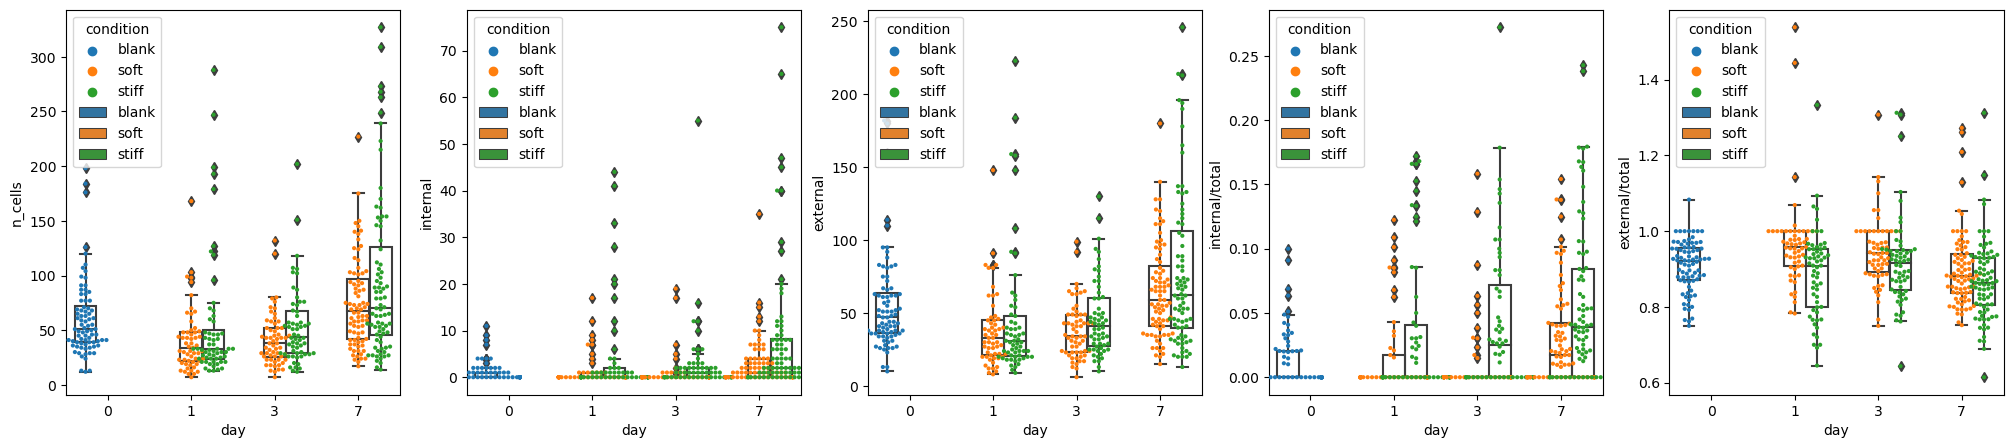

In [80]:
fig, ax = plt.subplots(ncols = 5, figsize=(25,5))
for i, param in enumerate(["n_cells", "internal", "external", "internal/total", "external/total"]):
    sns.swarmplot(data = average_morphology_measurements, x="day", y=param, hue="condition", dodge=True, ax = ax[i], size=3)
    sns.boxplot(data = average_morphology_measurements, x="day", y=param, hue="condition", dodge=True, ax = ax[i], boxprops={"facecolor":"None"})

In [48]:
# V scales r^3 though so is this still an artefact of the differences in volume among acini

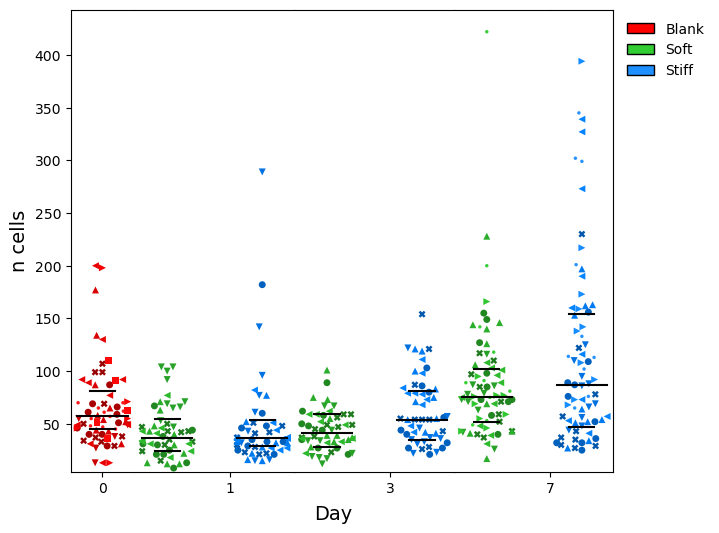

In [51]:
plot_acinar_differences(average_morphology_measurements, "n_cells", figsize=(7,6), spacing=0.01)